In [5]:
# Importing in each cell because of the kernel restarts.
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'https://www.birdwatchingdaily.com/',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for article in response.xpath('//article'):
            
            # Yield a dictionary with the values we want.
            yield {
                'name': article.xpath('div[@class="entry-header"]/h1/a/text()').extract_first(),
                 'date': article.xpath('div[@class="entry-header"]/p[@class="meta"]/span[@class="meta--date"]/text()').extract_first(),
                 'text': article.xpath('div[@class="entry-excerpt"]/p/text()').extract()
            }
        # Get the URL of the previous page.
        next_page = response.xpath('//div[@class="next-posts lower"]/a/@href').extract_first()
        
        # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
        # This finds the page number. The next segment of code prevents us from going beyond page 9.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 23:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Success!


In [8]:
import pandas as pd

firstpage = pd.read_json('data.json', orient='records')

In [9]:
firstpage.text = firstpage.text.map(lambda x: x[0])

In [12]:
firstpage = firstpage.loc[(firstpage.date >= '2017-09-01'),:]

In [15]:
firstpage['Month'] = firstpage.date.dt.month

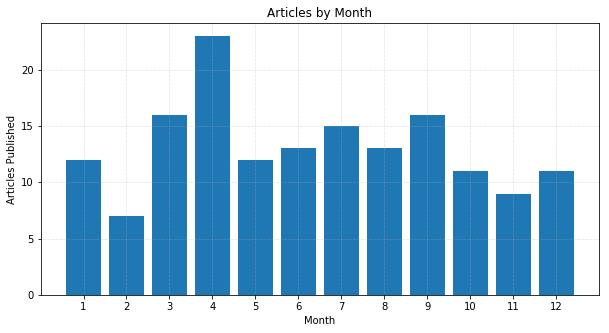

In [86]:
import matplotlib.pyplot as plt

#Plotting Articles per Month
x_apm = list(firstpage.Month.value_counts().index)
y_apm = list(firstpage.Month.value_counts().values)

plt.figure(figsize=(10,5))
plt.grid(linestyle='dotted', linewidth=0.5)
plt.bar(x_apm, y_apm)
plt.xticks(x_apm)
plt.xlabel('Month')
plt.ylabel('Articles Published')
plt.title('Articles by Month')
plt.show()

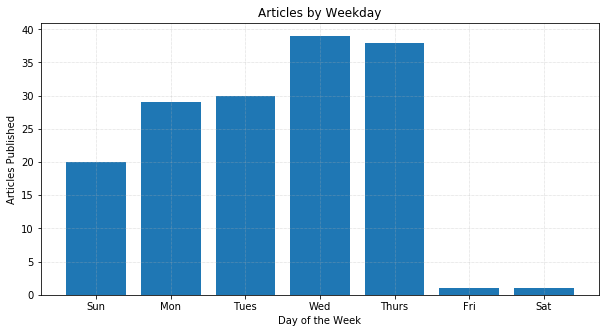

In [94]:
#Plotting Articles per Day
x_apd = list(firstpage.date.dt.dayofweek.value_counts().index)
y_apd = list(firstpage.date.dt.dayofweek.value_counts().values)

plt.figure(figsize=(10,5))
plt.grid(linestyle='dotted', linewidth=0.5)
plt.bar(x_apd, y_apd)
plt.xticks(x_apd, ['Wed','Thurs','Tues','Mon','Sun','Sat','Fri'])
plt.xlabel('Day of the Week')
plt.ylabel('Articles Published')
plt.title('Articles by Weekday')
plt.show()

In [ ]:
firstpage['Blob'] = (firstpage.name+' '+firstpage.text).str.lower()

In [99]:
len(firstpage[firstpage.Blob.map(lambda x: 'owl' in x)])

9

In [128]:
#Common Birds and their mentions
bird_list = ['owl', 'warbler','swallow', 'sparrow','jay','dove','crow']
birds=[]
for bird in bird_list:
    birds.append([bird,len(firstpage[firstpage.Blob.map(lambda x: bird in x)])])

bird_df = pd.DataFrame(birds)
bird_df.columns = ['Bird','Count']
bird_df.sort_values(by=['Count'], ascending=False, inplace=True)

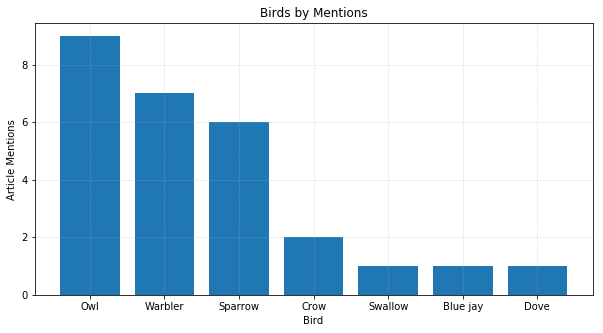

In [137]:
plt.figure(figsize=(10,5))
plt.bar(bird_df.Bird, bird_df.Count)
plt.grid(linestyle='dotted', linewidth=0.5)
plt.xticks(bird_df.Bird,['Owl','Warbler','Sparrow','Crow','Swallow','Blue jay','Dove'])
plt.xlabel('Bird')
plt.ylabel('Article Mentions')
plt.title('Birds by Mentions')
plt.show()